In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('Hitters.csv')
df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [24]:
df.isnull().sum()

Player        0
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [25]:
import math
median = df['Salary'].median()
print('The median is: {}'.format(median))

The median is: 425.0


In [26]:
df.update(df['Salary'].fillna(median))
print('The number of missing values is {}'.format(df['Salary'].isnull().sum()))

The number of missing values is 0


In [27]:
df = df.dropna().drop('Player', axis=1)
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df['Salary']
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
print(X.shape)
#Visualisation des 5 premieres lignes
X.head()

(322, 19)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
0,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,66.0,1.0,30.0,29.0,14.0,446.0,33.0,20.0,0,0,0
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1


In [28]:
def processSubset(feature_set):
    # Fit du model avec les predicteurs choisis -feature_set et calcul de RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"modele":regr, "RSS":RSS}

In [29]:
def getBestModel(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        # toutes les combinaisons de colonnes de X comme tuples
        results.append(processSubset(combo))
        # transformer le tout en dataframe pour une meilleure visualisation
        models = pd.DataFrame(results)
        #print(models.head())
        # Choisir le modele avec la valeur min de RSS
        best_model = models.loc[models['RSS'].argmin()]
        toc = time.time()
        print("Traitement de: ", models.shape[0], "modeles sur", k, "predicteurs en", (toc-tic), "secondes.")
        # Retourner le meilleur modele, avec d'autres information sur le modele
        return best_model

In [41]:
#Execution de la routine pour trouver le meilleur modele
models = pd.DataFrame(columns=["RSS", "modele"])
tic = time.time()
for i in range(1,3):
    models.loc[i] = getBestModel(i)
toc = time.time()
print("Total temps ecoulé: {:.6f} secondes".format(toc-tic))

Traitement de:  1 modeles sur 1 predicteurs en 0.008334159851074219 secondes.
Traitement de:  1 modeles sur 2 predicteurs en 0.007701873779296875 secondes.
Total temps ecoulé: 0.024144 secondes


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  # This is added back by InteractiveShellApp.init_path()


In [42]:
#Detail d'un modele avec 2 predicteurs en utilisant la fonction summary() :
print(models.loc[2, "modele"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     327.6
Date:                Mon, 08 Jul 2019   Prob (F-statistic):           3.73e-78
Time:                        16:36:40   Log-Likelihood:                -2367.1
No. Observations:                 322   AIC:                             4738.
Df Residuals:                     320   BIC:                             4746.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AtBat         -0.1564      0.464     -0.337      0.7

Text(0, 0.5, 'RSS')

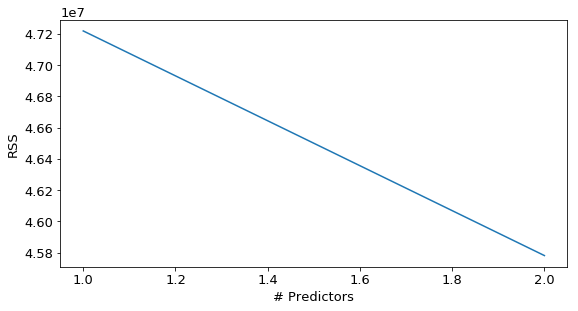

In [44]:
#Plotting RSS pour tous les modeles pour decider modele à selectionner
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 13, 'lines.markersize': 10})
# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)
# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


Text(0, 0.5, 'adjusted rsquared')

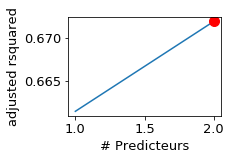

In [45]:
# plot a red dot pour le modele avec la plus grande R2 ajustée.
# The argmax() function can be used to identify the location of the maximum point of a vector
rsquared = models.apply(lambda row: row[1].rsquared, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared)
plt.plot(rsquared.argmax(), rsquared.max(), "or")
plt.xlabel('# Predicteurs')
plt.ylabel('adjusted rsquared')